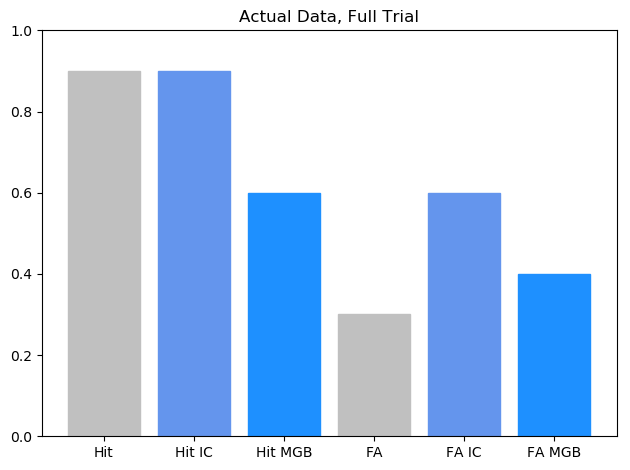

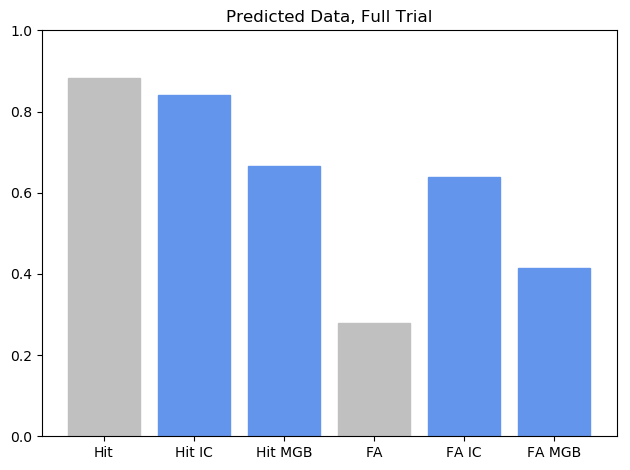

[ 3.09646276  2.74229749 -0.33548345 -2.09368533]


In [263]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
# this is to run the model for the full trial inactivation, for MGB and IC 
def four_param_model(x): # IC variance, MGB gain, criteria (no light), criteria (light)
    ICvar = x[0]
    MGBgain = x[1]
    cri = x[2]
    cri_opto = x[3]
    IC = build_distribution(1, ICvar, -1, ICvar)
    MGB = build_distribution(1, ICvar / MGBgain, -1, ICvar / MGBgain)

    expert = apply_criteria(MGB, cri)
    opto_IC = apply_criteria(IC, cri_opto)
    opto_MGB = apply_criteria(IC, cri)

    return np.array([expert['hit'], expert['fa'], opto_IC['hit'], opto_IC['fa'], opto_MGB['hit'], opto_MGB['fa']])

def build_distribution(t_mean, t_std, f_mean, f_std): 
    num_stimuli = 10000
    #target_strength = np.random.normal(t_mean, t_std, num_stimuli // 2)
    #foil_strength = np.random.normal(f_mean, f_std, num_stimuli // 2)
    target_strength = [t_mean, t_std]
    foil_strength = [f_mean, f_std]
    
    #stimuli = np.concatenate((target_strength, foil_strength))
    #label = np.concatenate((np.ones(num_stimuli // 2, dtype=bool), np.zeros(num_stimuli // 2, dtype=bool)))

    return {
        'target': target_strength,
        'foil': foil_strength
        #'stimuli': stimuli,
        #'label': label
    }

def my_error(x, y):
    return np.sum((y - four_param_model(x)) ** 2) + 0.000001 * sum(x**2 )

def apply_criteria(distribution, criterion):
    #hits = np.mean(distribution['target'] > criterion)
    hits = 1 - norm.cdf( (criterion-distribution['target'][0])/distribution['target'][1] ) #use cdf instead of building the distribution
    #false_alarms = np.mean(distribution['foil'] > criterion)
    false_alarms = 1 - norm.cdf( (criterion-distribution['foil'][0])/distribution['foil'][1] )
    return {'hit': hits, 'fa': false_alarms}

# Initial parameters
initial_guess = np.array([3, 4, 0, -3]) # IC variance, MGB gain, criteria (no light), criteria (light)
y = np.array([0.9, 0.3, 0.9, 0.6, 0.6, 0.4]) # hit r, fa r, hit ic, fa ic, hit mgb, fa mgb
out = four_param_model(initial_guess) # Actual Data
plt.figure()
barlist=plt.bar(range(1, 7), [y[0], y[2], y[4], y[1], y[3], y[5]])
barlist[0].set_color('silver')
barlist[1].set_color('dodgerblue')
barlist[2].set_color('dodgerblue')
barlist[3].set_color('silver')
barlist[4].set_color('dodgerblue')
barlist[5].set_color('dodgerblue')
plt.title('Actual Data, Full Trial')
plt.xticks(range(1, 7), ['Hit', 'Hit IC', 'Hit MGB', 'FA','FA IC', 'FA MGB'])
plt.tight_layout()
plt.ylim([0, 1])
plt.show()


# Minimize the error function
# this works!
result = minimize(my_error, np.array([1, 0, 0, 0]), args=(y,), bounds=[(1e-6, 100), (1e-6, 100), (-100, 100), (-100, 100)]) # test the model fit using random initial params
pred_behav = four_param_model(result.x) 
plt.figure()
barlist=plt.bar(range(1, 7),  [pred_behav[0], pred_behav[2], pred_behav[4], pred_behav[1], pred_behav[3], pred_behav[5]])
barlist[0].set_color('silver')
barlist[1].set_color('cornflowerblue')
barlist[2].set_color('cornflowerblue')
barlist[3].set_color('silver')
barlist[4].set_color('cornflowerblue')
barlist[5].set_color('cornflowerblue')
plt.title('Predicted Data, Full Trial')
plt.xticks(range(1, 7), ['Hit', 'Hit IC', 'Hit MGB', 'FA','FA IC', 'FA MGB'])
plt.tight_layout()
plt.ylim([0, 1])
plt.show()
print(result.x)

In [ ]:
# this is to plot the distributions for the block above
# 
x = initial_guess  # IC variance, MGB gain, criteria (no light), criteria (light)
ICvar = x[0]
MGBgain = x[1]
cri = x[2]
cri_opto = x[3]
IC = build_distribution(1, ICvar, -1, ICvar)
MGB = build_distribution(1, ICvar / MGBgain, -1, ICvar / MGBgain)

expert = apply_criteria(MGB, cri)
opto_IC = apply_criteria(IC, cri_opto)
opto_MGB = apply_criteria(IC, cri)
# Plot distributions 
def plot_distributions(IC, MGB):
    plt.figure(figsize=(8, 3))
    
    plt.subplot(1, 2, 1) # Plot IC distribution
    plt.hist(IC['target'], bins=30, alpha=0.5, label='Target (IC)', color='blue')
    plt.hist(IC['foil'], bins=30, alpha=0.5, label='Foil (IC)', color='orange')
    plt.plot([cri, cri], [0, 600],'black')
    plt.plot([cri_opto, cri_opto], [0, 600],'blue')
    plt.title('IC Distribution')
    plt.xlabel('Strength')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.subplot(1, 2, 2) # Plot MGB distribution
    plt.hist(MGB['target'], bins=30, alpha=0.5, label='Target (MGB)', color='blue')
    plt.hist(MGB['foil'], bins=30, alpha=0.5, label='Foil (MGB)', color='orange')
    plt.title('MGB Distribution')
    plt.plot([cri, cri], [0, 600],'black')
    plt.xlabel('Strength')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_distributions(IC, MGB) # Plot the distributions

plt.figure(figsize=(6, 3)) # Plot the predicted behavior
plt.bar(range(1, 7), pred_behav)
plt.title('Predicted Behavior')
plt.xticks(range(1, 7), ['Hit-exp', 'FA-exp', 'Hit-optoIC', 'FA-optoIC', 'Hit-optoMGB', 'FA-MGB'])
plt.show()

In [ ]:
# this is to run the model for the tone inactivation, for MGB and IC 
def four_param_model(x): # IC variance, MGB gain, criteria (no light), criteria (light)
    ICvar = x[0]
    MGBgain = x[1]
    cri = x[2]
    cri_opto = x[3]
    IC = build_distribution(1, ICvar, -1, ICvar)
    MGB = build_distribution(1, ICvar / MGBgain, -1, ICvar / MGBgain)

    expert = apply_criteria(MGB, cri)
    opto_IC = apply_criteria(IC, cri_opto)
    opto_MGB = apply_criteria(IC, cri)

    return np.array([expert['hit'], expert['fa'], opto_IC['hit'], opto_IC['fa'], opto_MGB['hit'], opto_MGB['fa']])

def build_distribution(t_mean, t_std, f_mean, f_std): 
    num_stimuli = 10000
    target_strength = np.random.normal(t_mean, t_std, num_stimuli // 2)
    foil_strength = np.random.normal(f_mean, f_std, num_stimuli // 2)
    
    stimuli = np.concatenate((target_strength, foil_strength))
    label = np.concatenate((np.ones(num_stimuli // 2, dtype=bool), np.zeros(num_stimuli // 2, dtype=bool)))

    return {
        'target': target_strength,
        'foil': foil_strength,
        'stimuli': stimuli,
        'label': label
    }

def my_error(x, y):
    return np.sum((y - four_param_model(x)) ** 2)

def apply_criteria(distribution, criterion):
    hits = np.mean(distribution['target'] > criterion)
    false_alarms = np.mean(distribution['foil'] > criterion)
    return {'hit': hits, 'fa': false_alarms}

# Initial parameters
initial_guess = np.array([1, 2, 0, 0]) # IC variance, MGB gain, criteria (no light), criteria (light)
y = np.array([0.9, 0.1, 0.9, 0.9, 0.6, 0.4])

out = four_param_model(initial_guess) # Actual Data
plt.figure()
barlist=plt.bar(range(1, 7), [out[0], out[2], out[4], out[1], out[3], out[5]])
barlist[0].set_color('silver')
barlist[1].set_color('cornflowerblue')
barlist[2].set_color('dodgerblue')
barlist[3].set_color('silver')
barlist[4].set_color('cornflowerblue')
barlist[5].set_color('dodgerblue')
plt.title('Actual Data, Full Trial')
plt.xticks(range(1, 7), ['Hit', 'Hit IC', 'Hit MGB', 'FA','FA IC', 'FA MGB'])
plt.tight_layout()
plt.ylim([0, 1])
plt.show()

# Minimize the error function
result = minimize(my_error, initial_guess, args=(y,), bounds=[(1e-6, 100), (1e-6, 100), (-100, 100), (-100, 100)])
pred_behav = four_param_model(result.x) 
plt.figure()
barlist=plt.bar(range(1, 7),  [pred_behav[0], pred_behav[2], pred_behav[4], pred_behav[1], pred_behav[3], pred_behav[5]])
barlist[0].set_color('silver')
barlist[1].set_color('cornflowerblue')
barlist[2].set_color('dodgerblue')
barlist[3].set_color('silver')
barlist[4].set_color('cornflowerblue')
barlist[5].set_color('dodgerblue')
plt.title('Predicted Data, Full Trial')
plt.xticks(range(1, 7), ['Hit', 'Hit IC', 'Hit MGB', 'FA','FA IC', 'FA MGB'])
plt.tight_layout()
plt.ylim([0, 1])
plt.show()